# Implementation of linear quadratic regulator
This implementation tries to control a quadrotor to stay on a given trajectory using LQR for control in a Mujoco environment.  
Model of the quadrotor comes from the reinmav-gym repo: https://github.com/ethz-asl/reinmav-gym/blob/

In [131]:
import math

def quat2eulers(q0:float, q1:float, q2:float, q3:float) -> tuple:
    """
    Compute yaw-pitch-roll Euler angles from a quaternion.
    
    Args
    ----
        q0: Scalar component of quaternion.
        q1, q2, q3: Vector components of quaternion.
    
    Returns
    -------
        (roll, pitch, yaw) (tuple): 321 Euler angles in radians
    """
    roll = math.atan2(
        2 * ((q2 * q3) + (q0 * q1)),
        q0**2 - q1**2 - q2**2 + q3**2
    )  # radians
    pitch = math.asin(2 * ((q1 * q3) - (q0 * q2)))
    yaw = math.atan2(
        2 * ((q1 * q2) + (q0 * q3)),
        q0**2 + q1**2 - q2**2 - q3**2
    )
    return (roll, pitch, yaw)

In [132]:
quat2eulers(1, 0, 0, 0)

(0.0, 0.0, 0.0)

In [133]:
import jax
from jax import numpy as jnp
import mujoco
from mujoco import mjx
import mediapy as media
import pid
import matplotlib.pyplot as plt
import lqr
from scipy.spatial.transform import Rotation

## Constants
Constant values used to create the A and B matrix for a dynamical model of the quadrotor

In [134]:
quadrotor_inertia = [0.0034, 0.0018, 0.017]
quadrotor_mass = 0.3
gravity_constant = 9.81

In [135]:
A = lqr.create_state_matrix(quadrotor_mass, quadrotor_inertia[0], quadrotor_inertia[1], quadrotor_inertia[2], gravity_constant)
A

Array([[ 0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -9.81,  0.  ,
         0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  9.81,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         1.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  1.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  1.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  

In [136]:
B = lqr.create_input_matrix(quadrotor_mass, quadrotor_inertia[0], quadrotor_inertia[1], quadrotor_inertia[2])
B

Array([[  0.       ,   0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ,   0.       ],
       [  3.3333333,   0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ,   0.       ],
       [  0.       , 294.11765  ,   0.       ,   0.       ],
       [  0.       ,   0.       , 555.55554  ,   0.       ],
       [  0.       ,   0.       ,   0.       ,  58.82353  ]],      dtype=float32)

In [137]:
Q =  jnp.eye(12)
Q

Array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [143]:
R = 0.01 * jnp.eye(4)
R

Array([[0.01, 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.01]], dtype=float32)

In [148]:

reference_point = jnp.array([0, 0, 1, 0,0,0,0,0,0,0,0,0])
initial_state = jnp.array([0.01, 1.5e-16, 1, 2e-17, 1e-18,2e-15,16e-17,0.00001,0.000002,0,0,0])


In [149]:
xml = """
<mujoco model="quadrotor0">
	<compiler inertiafromgeom="true" coordinate="local"/>
	<option	timestep="0.01" gravity="0 0 -9.81" density="1" viscosity="1e-5" />
	<worldbody>
		<geom name="floor" pos="0 0 0" size="2 2 .2" type="plane"  conaffinity="1" rgba="1 1 1 1" condim="3"/>
		<body name="quadrotor" pos="0 0 0" >
			<geom name="core" type="box" pos="0 0 0" quat = "1. 0. 0. 0." size="0.06 0.035 0.025"  rgba="0.3 0.3 0.8 1" mass = ".1"/>

			<geom name="a00" type="box" pos=".071 0.071 0.0" size="0.05 0.01 0.0025"  quat = ".924 0.0 0.0 0.383" rgba="0.3 0.3 0.8 1" mass = ".025"/>
			<geom name="a10" type="box" pos=".071 -0.071 0.0" size="0.05 0.01 0.0025"  quat = ".383 0.0 0.0 0.924" rgba="0.3 0.3 0.8 1" mass = ".025"/>
			<geom name="a20" type="box" pos="-0.071 -0.071 0.0" size="0.05 0.01 0.0025"  quat = "-.383 0.0 0.0 0.924" rgba="0.3 0.3 0.8 1" mass = ".025"/>
			<geom name="a30" type="box" pos="-.071 0.071 0.0" size="0.05 0.01 0.0025"  quat = ".924 0.0 0.0 -0.383" rgba="0.3 0.3 0.8 1" mass = ".025"/>

			<joint name="root"   type="free" damping="0" armature="0" pos="0 0 0" />


			<!-- Motor sites to attach motor actuators -->
            <site name="motor0" type="cylinder" pos=" 0.1  0.1 0.01"  size="0.01 0.0025"  quat = "1.0 0.0 0.0 0." rgba="0.3 0.8 0.3 1"/>
            <site name="motor1" type="cylinder" pos=" 0.1 -0.1 0.01"  size="0.01 0.0025"  quat = "1.0 0.0 0.0 0." rgba="0.3 0.8 0.3 1"/>
            <site name="motor2" type="cylinder" pos="-0.1 -0.1 0.01"  size="0.01 0.0025"  quat = "1.0 0.0 0.0 0." rgba="0.3 0.8 0.3 1"/>
            <site name="motor3" type="cylinder" pos="-0.1  0.1 0.01"  size="0.01 0.0025"  quat = "1.0 0.0 0.0 0." rgba="0.3 0.8 0.3 1"/>

			<!-- Thruster geometries for collisions since site's are excluded from collision checking -->
            <geom name="thruster0" type="cylinder" pos=" 0.1  0.1  0.01" size="0.05 0.0025"  quat = "1.0 0.0 0.0 0." rgba="0.3 0.8 0.3 1" mass = ".025"/>
            <geom name="thruster1" type="cylinder" pos=" 0.1 -0.1  0.01" size="0.05 0.0025"  quat = "1.0 0.0 0.0 0." rgba="0.3 0.8 0.3 1" mass = ".025"/>
            <geom name="thruster2" type="cylinder" pos="-0.1 -0.1  0.01" size="0.05 0.0025"  quat = "1.0 0.0 0.0 0." rgba="0.3 0.8 0.3 1" mass = ".025"/>
            <geom name="thruster3" type="cylinder" pos="-0.1  0.1  0.01" size="0.05 0.0025"  quat = "1.0 0.0 0.0 0." rgba="0.3 0.8 0.3 1" mass = ".025"/>

            <!-- Visualization of the coordinate frame -->
			<site name="qcX" type="box" pos="0.1 0.0 0.0" size="0.1 0.005 0.005"  quat = " 1.000  0.0  0.0    0."     rgba="1 0 0 1" />
			<site name="qcY" type="box" pos="0.0 0.1 0.0" size="0.1 0.005 0.005"  quat = " 0.707  0.0  0.0    0.707"  rgba="0 1 0 1" />
			<site name="qcZ" type="box" pos="0.0 0.0 0.1" size="0.1 0.005 0.005"  quat = "-0.707  0.0  0.707  0."     rgba="0 0 1 1" />
		</body>
		
	</worldbody>
    <actuator>
        <motor ctrllimited="true" ctrlrange="0.0 1.0" gear="0  0. 1. 0. 0. -0.1" site="motor0"/>
        <motor ctrllimited="true" ctrlrange="0.0 1.0" gear="0  0. 1. 0. 0.  0.1" site="motor1"/>
        <motor ctrllimited="true" ctrlrange="0.0 1.0" gear="0  0. 1. 0. 0. -0.1" site="motor2"/>
        <motor ctrllimited="true" ctrlrange="0.0 1.0" gear="0  0. 1. 0. 0.  0.1" site="motor3"/>
	</actuator>
</mujoco>
"""

In [150]:
mj_model = mujoco.MjModel.from_xml_string(xml)
mj_data = mujoco.MjData(mj_model)
renderer = mujoco.Renderer(mj_model)

mjx_model = mjx.put_model(mj_model)
mjx_data = mjx.put_data(mj_model, mj_data)
controller = pid.PID(0.003, 0.9, 2)
lqr_controller = lqr.LQR(reference_point, A, B, R, Q, initial_state, 1000)
lqr_controller.calculate_gain()
optimal_controls = lqr_controller.control_trajectory()
infinite_horizon_controller = lqr.CTIHLQR(reference=reference_point, A=A, B=B, Q=Q, R=R, initial_state=jnp.array([0.01, 1.5e-16, 0, 2e-17, 1e-18,2e-15,16e-17,0.00001,0.000002,0,0,0]))
infinite_horizon_controller.calculate_gain()
infinite_horizon_controller.gain

Array([[-1.23510084e-14,  1.58537090e-14,  1.00000000e+01,
        -3.21396826e-14,  8.50860859e-15,  1.02956295e+01,
         2.22010165e-14,  7.51767219e-14,  2.71258723e-15,
         5.82499926e-18, -1.93381023e-16,  4.90978810e-17],
       [-5.98611779e-15,  1.00000000e+01, -6.35061470e-15,
         3.52121151e-14,  1.45186338e+01,  5.13970540e-16,
         5.43428688e+01,  1.33543228e-13, -2.77692573e-15,
         1.00184593e+01, -1.71556359e-16,  4.48787106e-17],
       [-1.00000000e+01, -7.46493050e-14, -9.51399441e-13,
        -1.45170355e+01, -3.14704250e-14, -3.22301728e-14,
        -7.25486511e-13,  5.43200989e+01,  4.68354290e-15,
        -3.24050903e-16,  1.00097723e+01,  4.85694251e-16],
       [ 4.06175473e-14,  8.55662722e-14,  1.43372551e-13,
        -1.21966321e-13,  9.45095917e-14,  8.66433231e-16,
         4.15032754e-13,  1.38308093e-13,  1.00000000e+01,
         8.97574262e-18,  5.14264540e-17,  1.00169859e+01]],      dtype=float32)

In [151]:
# enable joint visualization option:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

duration = 10  # (seconds)
framerate = 60  # (Hz)

frames = []
index = 0
altitudes = []
commands = []
mujoco.mj_resetData(mj_model, mj_data)
""" rot = Rotation.from_euler('xyz', [10, 0, 0], degrees=True)  # Example: 10°, 20°, 30° rotation
quat = rot.as_quat()
mj_data.qpos[3:7] = [quat[3], quat[0], quat[1], quat[2]]
print(quat) """
while mj_data.time < duration:
  mujoco.mj_step(mj_model, mj_data)
  
  positions = mj_data.qpos[0:3]
  position_velocities = mj_data.qvel[0:3]
  quaternion = mj_data.qpos[3:7]
  quat_xyzw = [quaternion[1], quaternion[2], quaternion[3], quaternion[0]]

  rotation_matrix = Rotation.from_quat(quat_xyzw)

  roll, pitch, yaw = rotation_matrix.as_euler('xyz', degrees=False)
  omega_body = mj_data.qvel[3:6]

  phi = roll
  theta = pitch

  c_phi = jnp.cos(phi)
  s_phi = jnp.sin(phi)
  t_theta = jnp.tan(theta)
  sec_theta = 1 / jnp.cos(theta)

  T = jnp.array([
      [1, s_phi * t_theta, c_phi * t_theta],
      [0, c_phi, -s_phi],
      [0, s_phi * sec_theta, c_phi * sec_theta]
  ])

  euler_rates = T @ omega_body
  roll_rate, pitch_rate, yaw_rate = euler_rates
  current_state = jnp.concatenate([positions, position_velocities, jnp.array([roll, pitch, yaw]), jnp.array([roll_rate, pitch_rate, yaw_rate]) ])
  if mj_data.time > 0: 
    inputs = infinite_horizon_controller.control(current_state)

    
    print(f'inputs: {inputs}')
    #print(f'state: {current_state - reference_point}')
    controls = lqr.control_to_motor_forces(inputs, 0.02)

    mj_data.ctrl = controls 


    commands.append(current_state[2])
  else:
    infinite_horizon_controller.prev_state = current_state
    
  if len(frames) < mj_data.time * framerate:
    renderer.update_scene(mj_data, scene_option=scene_option)
    pixels = renderer.render()
    frames.append(pixels)

  index += 1
# Simulate and display video.
media.show_video(frames, fps=framerate)

inputs: [ 3.2628355e+00 -2.2298291e-15 -9.2108233e-13  1.4185388e-13]
Another mixing algo: [3.2628355 3.2628355 3.2628355 3.2628355]
inputs: [ 2.8366785e+00 -2.6821959e-15 -9.1296263e-13  1.4084476e-13]
Another mixing algo: [2.8366785 2.8366785 2.8366785 2.8366785]
inputs: [ 2.4075866e+00 -3.1321796e-15 -9.0451458e-13  1.3978593e-13]
Another mixing algo: [2.4075866 2.4075866 2.4075866 2.4075866]
inputs: [ 1.9755936e+00 -3.5812938e-15 -8.9573824e-13  1.3867745e-13]
Another mixing algo: [1.9755936 1.9755936 1.9755936 1.9755936]
inputs: [ 1.5407324e+00 -4.0307562e-15 -8.8663490e-13  1.3751944e-13]
Another mixing algo: [1.5407324 1.5407324 1.5407324 1.5407324]
inputs: [ 1.1030350e+00 -4.4815107e-15 -8.7720483e-13  1.3631196e-13]
Another mixing algo: [1.103035 1.103035 1.103035 1.103035]
inputs: [ 6.6253471e-01 -4.9342447e-15 -8.6744880e-13  1.3505511e-13]
Another mixing algo: [0.6625347 0.6625347 0.6625347 0.6625347]
inputs: [ 6.8702030e-01 -5.3863418e-15 -8.5946712e-13  1.3382574e-13]
Ano

Text(0, 0.5, 'Cost')

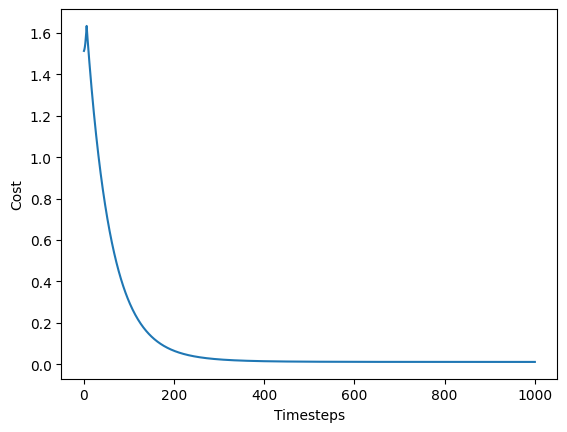

In [152]:
plt.plot(range(len(infinite_horizon_controller.losses)), infinite_horizon_controller.losses)
plt.xlabel("Timesteps")
plt.ylabel("Cost")

# Some experiments with discrete time LQR
TLDR; kindof wrong implementation but should be implemented better for another task

In [18]:
# enable joint visualization option:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

duration = 10  # (seconds)
framerate = 60  # (Hz)

frames = []
index = 0
mujoco.mj_resetData(mj_model, mj_data)
while mj_data.time < duration:
  mujoco.mj_step(mj_model, mj_data)
  print(mj_data.qvel) 

  inputs = optimal_controls[index]
  motor_commands = lqr.compute_motor_commands(inputs, 0.3, 9.81, 0.05, 1, 1)
  mj_data.ctrl = motor_commands

  if len(frames) < mj_data.time * framerate:
    renderer.update_scene(mj_data, scene_option=scene_option)
    pixels = renderer.render()
    frames.append(pixels)

  index += 1
# Simulate and display video.
media.show_video(frames, fps=framerate)

[-1.74579637e-35  3.13189136e-36 -9.81000000e-02 -1.93995470e-33
  4.65726742e-33  1.99064142e-51]
[ 0.00119734 -0.00271753 -0.12983393 -0.81525841 -0.35920091  0.00276419]
[ 0.00095775  0.00179778 -0.16125676  0.37620509 -0.35920822  0.00269568]
[ 4.78667525e-04 -1.88059161e-03 -1.92636618e-01 -8.15183069e-01
 -3.59183879e-01  2.72729558e-03]
[-2.40424769e-04  2.92761377e-03 -2.24060516e-01  3.76280286e-01
 -3.59190889e-01  2.65879632e-03]
[-1.19895433e-03 -4.57719533e-04 -2.55402764e-01 -8.15108008e-01
 -3.59166685e-01  2.69041307e-03]
[-0.00239784  0.00464347 -0.28682364  0.37635521 -0.3591734   0.00262192]
[-0.00383645  0.00155143 -0.31812423 -0.81503322 -0.35914933  0.00265354]
[-0.00551556  0.0069458  -0.34953809  0.37642985 -0.35915576  0.00258506]
[-0.00743503  0.00414739 -0.38079309 -0.81495871 -0.35913182  0.00261669]
[-0.00959494  0.0098352  -0.41219604  0.37650422 -0.35913796  0.00254822]
[-0.01199617  0.00733084 -0.44340165 -0.81488448 -0.35911416  0.00257985]
[-0.0146376 

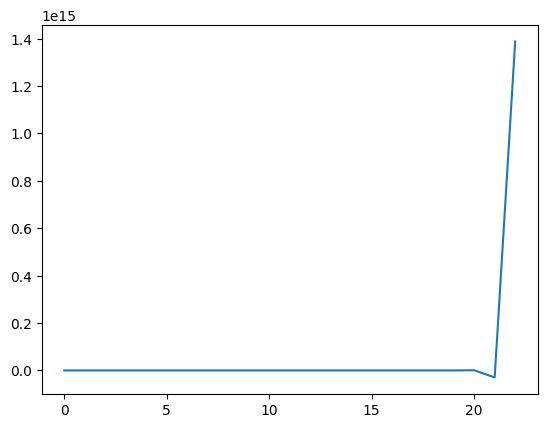

In [21]:
torque_1 = lqr_controller.outputs[:, 8]

plt.plot(range(1000), torque_1)